In [38]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp

import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_calcium_base as pl


In [2]:
'''

If you don't have calcium signal, this part simulates the calcium activity
from a place cell in a 2D enviroment.

You should first set your environment edges. You can think of it as a retangular box in cm.
environment_edges = [[0,30],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]

Now set the number of place fields (if num_of_fields = 0, then the cell is not a place cell),
their location in the enviroment, and their respective sizes.

'''

"\n\nIf you don't have calcium signal, this part simulates the calcium activity\nfrom a place cell in a 2D enviroment.\n\nYou should first set your environment edges. You can think of it as a retangular box in cm.\nenvironment_edges = [[0,30],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]\n\nNow set the number of place fields (if num_of_fields = 0, then the cell is not a place cell),\ntheir location in the enviroment, and their respective sizes.\n\n"

In [3]:
# Cell simulation parameters

sampling_rate = 30. # points/frames per second
duration = 500 # in seconds
rate = 10 # how much your neuron should spike
environment_edges = [[0,30],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]

num_of_fields = 2

# Define field parameters
field1_center = (20, 35)
field2_center = (10, 5)
field3_center = (5, 30)
field1_size = 4
field2_size = 2
field3_size = 2



In [4]:

x_coordinates,y_coordinates,speed,time_vector = cs_model.generate_random_walk(input_srate = sampling_rate,input_total_Time = duration,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = time_vector.shape[0]

spike_times = cs_model.generate_poisson_spikes(rate, duration)
spike_times_idx = (spike_times*sampling_rate).astype(int)


if num_of_fields == 0:
    modulated_spike_times_idx = spike_times_idx.copy()
else:
    modulated_spike_times_idx = []
    for counter in range(num_of_fields):
        field_center = eval('field' + str(counter+1) + '_center')
        field_size = eval('field' + str(counter+1) + '_size')
        modulated_spike_times_idx_aux = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,spike_times_idx,x_center = field_center[0],y_center = field_center[1], s = field_size)
    
        modulated_spike_times_idx.append(modulated_spike_times_idx_aux)
    modulated_spike_times_idx = np.unique(np.concatenate(modulated_spike_times_idx))
    
signal,time_vector = cs_model.generate_calcium_signal(modulated_spike_times_idx,total_points,sampling_rate,noise_level = 0.01, b = 5.)
peaks_idx = dp.detect_peaks(signal,mpd=0.5*sampling_rate,mph=1.*np.nanstd(signal))


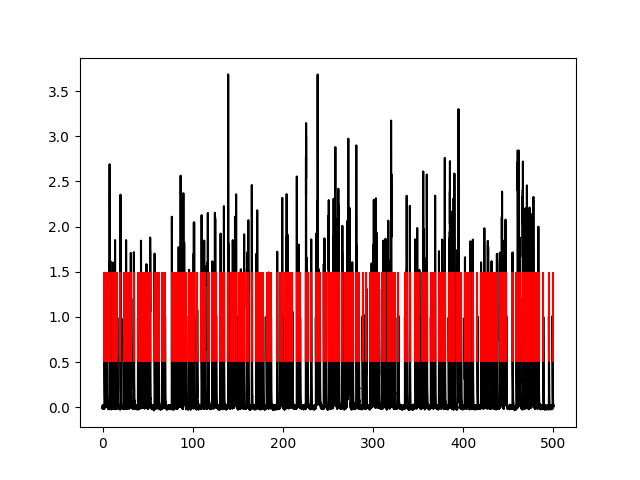

In [5]:

plt.figure()
plt.plot(time_vector, signal,'k')
plt.eventplot(time_vector[modulated_spike_times_idx],color='red')
plt.show()


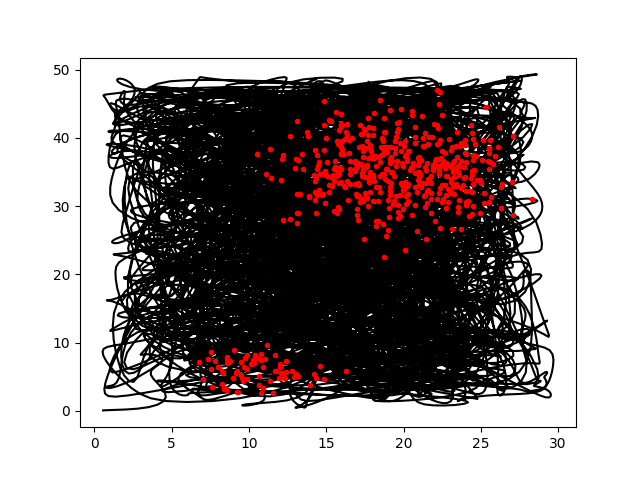

In [6]:

plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k')
plt.plot(x_coordinates[modulated_spike_times_idx],y_coordinates[modulated_spike_times_idx],color = 'red',linestyle='',marker='.',markersize=6)
# plt.gca().set_aspect('equal', 'box')
plt.show()


In [7]:
'''

If you already have a calcium signal, you can skip the part above and load your data here.

'''

'\n\nIf you already have a calcium signal, you can skip the part above and load your data here.\n\n'

In [8]:

'''
- Parameters to assist in creating a filename and saving it. However, if you prefer 
to save the object itself, you can safely ignore this by setting the 'saving' flag to False.

- Filename Constructor:
    'saving_string': Prefix string used for creating a filename to save the results.
    'animal_id': Animal identifier.
    'dataset': Dataset name.
    'day': Session or day.
    'neuron': Neuron identifier.
    'trial': Trial identifier.
    'saving_path': Path for saving the results.
    'saving': A boolean flag indicating whether to save the results.

- Parameters:
    'sampling_rate': Sampling rate for the signal and tracking.
    'environment_edges': Edges of the environment using coordinates units.

- Inclusion Criteria:
    'min_time_spent': Minimum time an animal must spend in each xy bin.
    'min_visits': Minimum number of visits required in each xy bin.
    'min_speed_threshold': Minimum speed threshold using coordinates units.

- Information Parameters:
    'x_bin_size': Size of x bins, measured in coordinates units, used to calculate mutual information.
    'y_bin_size': Size of y bins, measured in coordinates units, used to calculate mutual information.
    'nbins_cal': Number of signal bins used to calculate mutual information.
    
- Surrogate Parameters:
    'shift_time': Time shift window in seconds. It is used to create a surrogate distribution of the 
        signal by randomly shifting it from -shift_time to +shift_time.
    'num_cores': The number of CPU cores to be used. Set to -1 to utilize all available CPU cores.
    'num_surrogates': Number of surrogates.

- Place Field Parameters:
    'smoothing_size': Smoothing area in bins to plot place fields.
    'percentile_threshold': Percentile threshold used to calculate place field boundaries based on the surrogate distribution.
    'min_num_of_pixels': Minimum number of bins that define a place field.

This analysis assumes that all input variables (input_signal, time_vector, x_coordinates, y_coordinates)
consist of vectors of the same size. You may need to downsample or upsample your signal or xy tracking 
coordinates to ensure their shapes match.

'''

"\n- Parameters to assist in creating a filename and saving it. However, if you prefer \nto save the object itself, you can safely ignore this by setting the 'saving' flag to False.\n\n- Filename Constructor:\n    'saving_string': Prefix string used for creating a filename to save the results.\n    'animal_id': Animal identifier.\n    'dataset': Dataset name.\n    'day': Session or day.\n    'neuron': Neuron identifier.\n    'trial': Trial identifier.\n    'saving_path': Path for saving the results.\n    'saving': A boolean flag indicating whether to save the results.\n\n- Parameters:\n    'sampling_rate': Sampling rate for the signal and tracking.\n    'environment_edges': Edges of the environment using coordinates units.\n\n- Inclusion Criteria:\n    'min_time_spent': Minimum time an animal must spend in each xy bin.\n    'min_visits': Minimum number of visits required in each xy bin.\n    'min_speed_threshold': Minimum speed threshold using coordinates units.\n\n- Information Parame

In [9]:
# Signal processing
# here you can modify your signal to test different preprocessing steps.
# then, choose one of them as the input_signal 

lower_band = 0
higher_band = 2
filtered_signal = hf.eegfilt(signal, sampling_rate, lower_band, higher_band, order=2)

diff_signal = np.hstack([np.diff(filtered_signal), 0])

diff_signal_truncated = np.copy(diff_signal)
diff_signal_truncated[diff_signal < 0] = 0



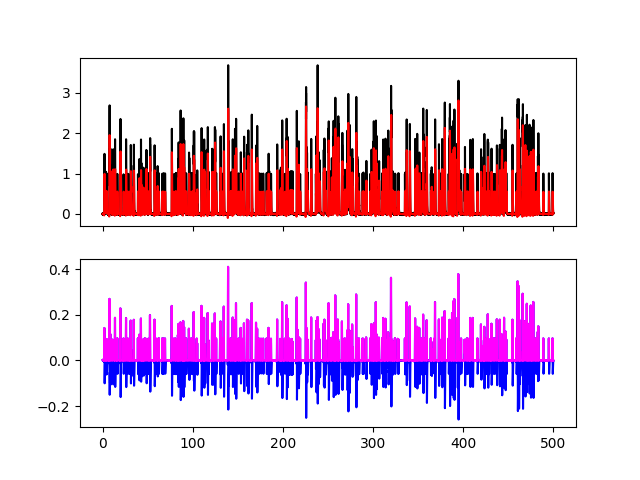

In [10]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(time_vector,signal,color = 'black')
ax1.plot(time_vector,filtered_signal,color ='red')

ax2.plot(time_vector,diff_signal,color ='blue')
ax2.plot(time_vector,diff_signal_truncated,color ='magenta')
plt.show()


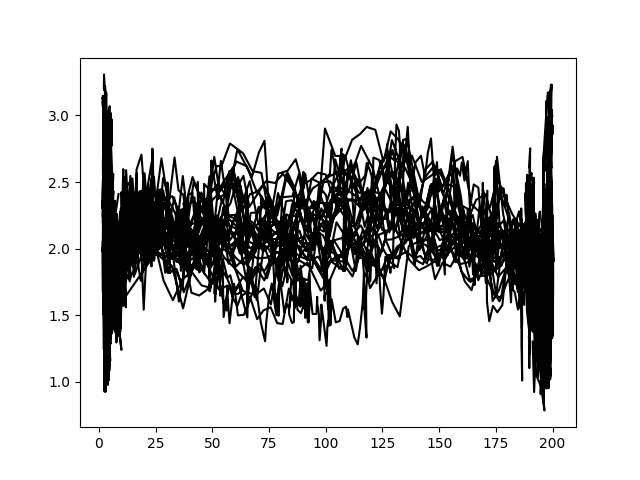

In [61]:
import pandas as pd
os.chdir('/home/apolo/Documents/github_projects/information_metrics/data/hanna/')

environment_edges = [[0,200],[0,4]] 

time_vector = np.load('time_vector.pickle',allow_pickle=True)
x_coordinates = np.load('x_coordinates.pickle',allow_pickle=True)
y_coordinates = np.load('y_coordinates.pickle',allow_pickle=True)
sampling_rate = 1/np.nanmean(np.diff(time_vector))

# Load the pickle file using pandas
df = pd.read_pickle('traces_neuron8.pickle')
signal = np.array(df)
# signal = hf.min_max_norm(signal,custom_min=0,custom_max=1)

plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k')
# plt.gca().set_aspect('equal', 'box')
plt.show()


In [65]:
# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
# sampling_rate = 1/np.nanmean(np.diff(time_vector))

# now input_signal will point to the signal you choose
signal_type = 'Raw'
input_signal = signal

# signal_type = 'Filtered'
# input_signal = filtered_signal

# signal_type = 'Diff'
# input_signal = diff_signal

# signal_type = 'Diff_truncated'
# input_signal = diff_signal_truncated


input_dict = dict()

# filename constructor
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['saving_path'] = None
input_dict['saving'] = False
 
input_dict['sampling_rate'] = sampling_rate # in points per second
input_dict['environment_edges'] = environment_edges # in cm

# inclusion criteria
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 
input_dict['speed_smoothing_points'] = int(np.round(0.1*sampling_rate)) # speed gaussian smoothing in seconds

# information parameters
input_dict['x_bin_size'] = 2 # x bin size in cm
input_dict['y_bin_size'] = 0.2 # y bin size in cm
input_dict['nbins_cal'] = 10

# surrogate parameters
input_dict['shift_time'] = 200
input_dict['num_cores'] = -1
input_dict['num_surrogates'] = 800

# place field parameters
input_dict['smoothing_size'] = 2
input_dict['percentile_threshold'] = 99
input_dict['min_num_of_pixels'] = 4

place_cell = pl.PlaceCell(**input_dict)
place_cell_output = place_cell.main(input_signal,time_vector,x_coordinates,y_coordinates)


SpatialMetrics.Raw.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


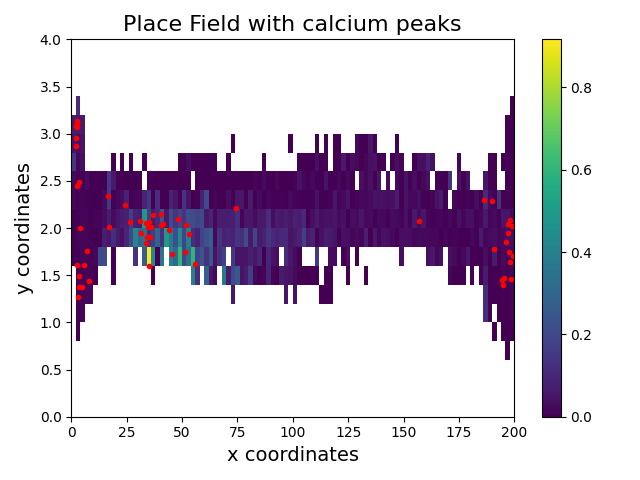

In [64]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'],shading = 'auto',edgecolors=None)
# plt.pcolormesh(place_cell_output['x_grid'],place_cell_output['y_grid'],place_cell_output['place_field'],edgecolors='red')

plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



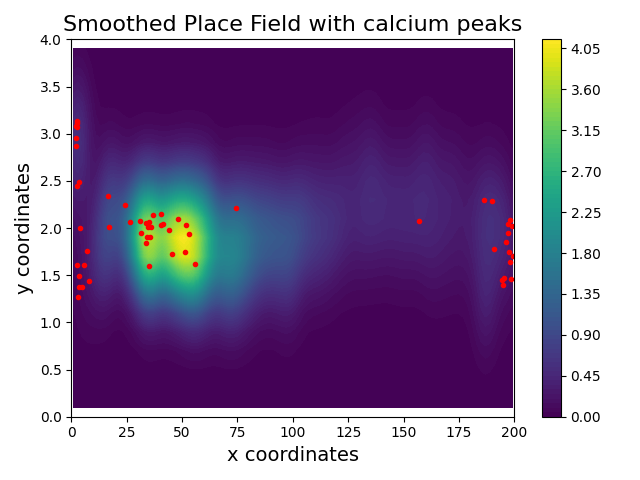

In [43]:


plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100,cmap='viridis')
plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



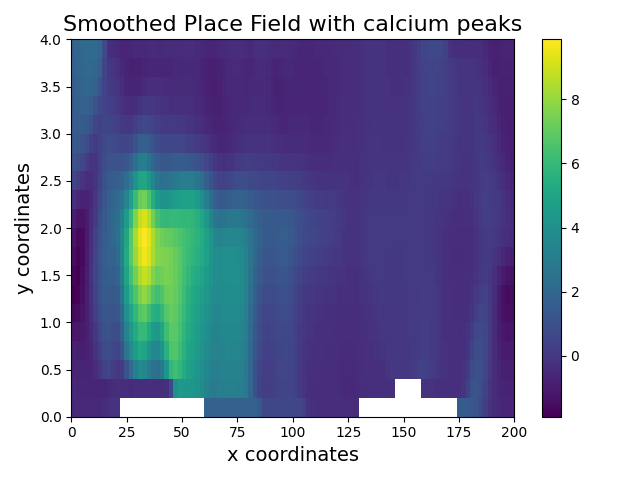

In [44]:

mean_place_field_shifted = np.nanmean(place_cell_output['place_field_smoothed_shifted'],0)
std_place_field_shifted = np.nanstd(place_cell_output['place_field_smoothed_shifted'],0)
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_smoothed_zscored = (place_field_smoothed - mean_place_field_shifted)/std_place_field_shifted

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_field_smoothed_zscored)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


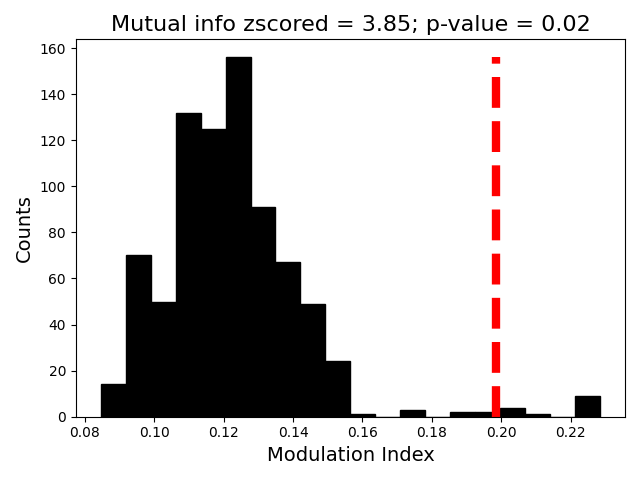

In [66]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shifted'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


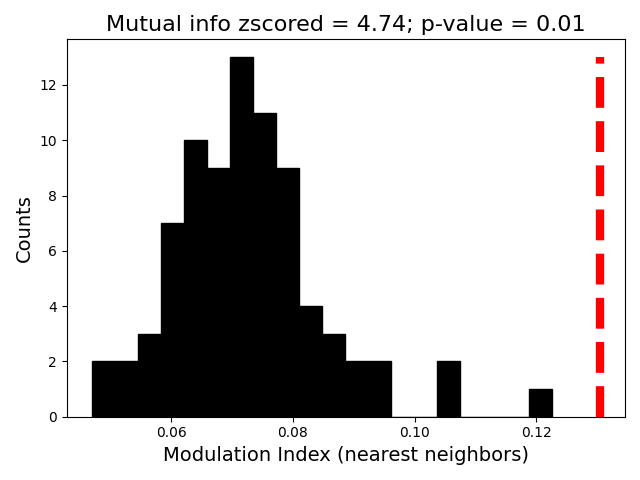

In [47]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_NN_shifted'] >= place_cell_output['mutual_info_NN_original'])/place_cell_output['mutual_info_NN_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_NN_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_NN_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_NN_original'],place_cell_output['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


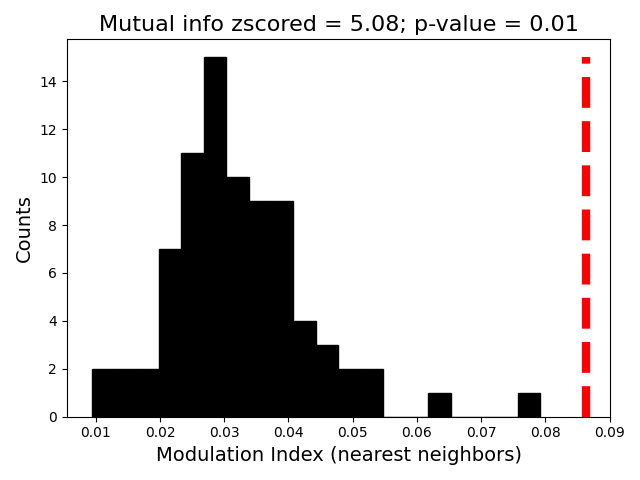

In [46]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_regression_shifted'] >= place_cell_output['mutual_info_regression_original'])/place_cell_output['mutual_info_regression_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_regression_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_regression_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_regression_original'],place_cell_output['mutual_info_regression_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_regression_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


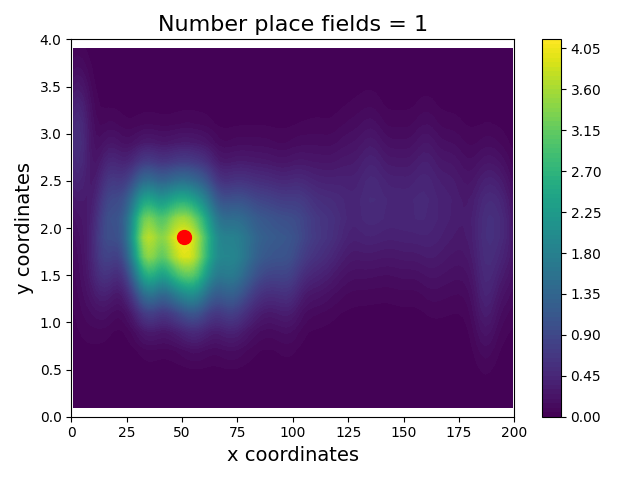

In [48]:
# place field identity and location

plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100)
plt.colorbar()
plt.plot(place_cell_output['x_center_bins'][place_cell_output['islands_x_max']],place_cell_output['y_center_bins'][place_cell_output['islands_y_max']],color='red',linestyle='',marker='.',markersize=20)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


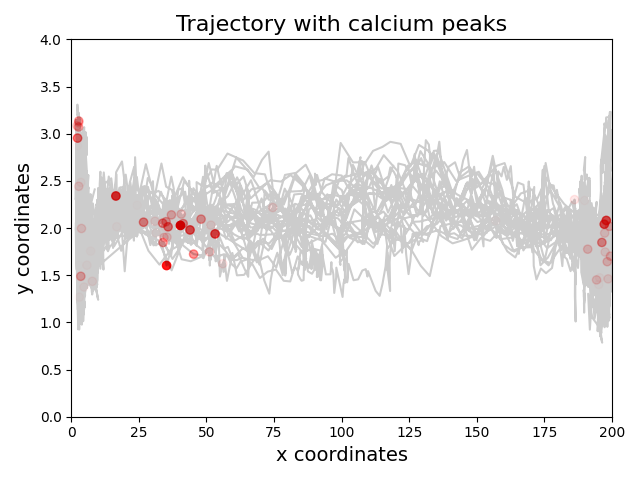

In [49]:
# The function normalizes peak amplitudes and uses them to set the transparency of each peak.
# Peaks with higher amplitudes are darker (less transparent) in the plot.

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


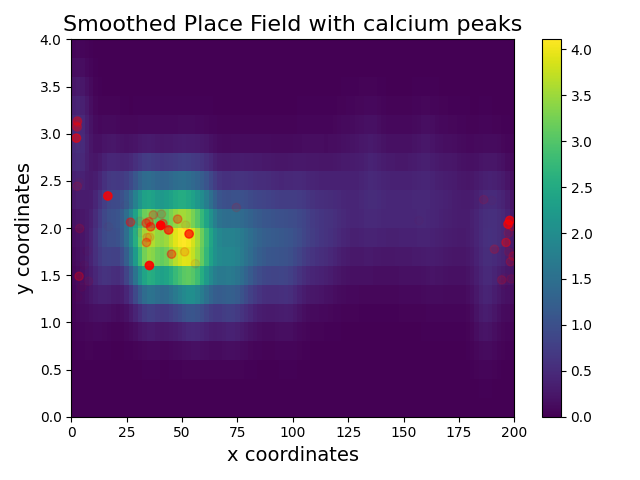

In [50]:
x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


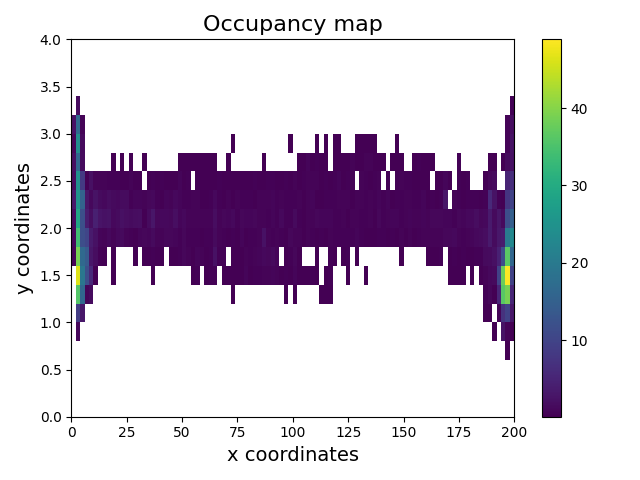

In [51]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['occupancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


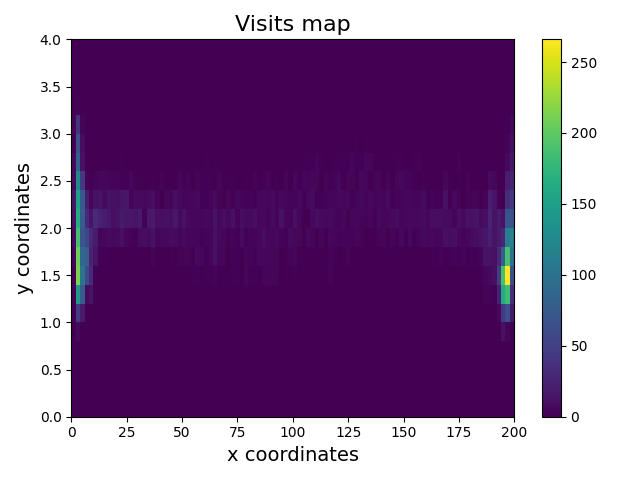

In [57]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


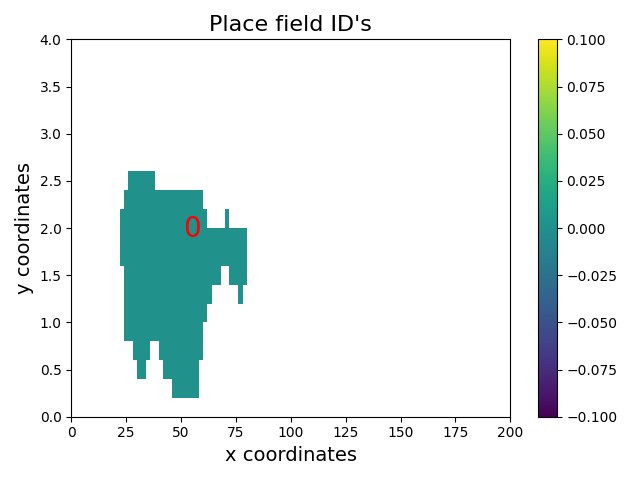

In [52]:
place_cells_x_center_coord = place_cell_output['x_center_bins'][place_cell_output['islands_x_max']]
place_cells_y_center_coord = place_cell_output['y_center_bins'][place_cell_output['islands_y_max']]

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_identity'])
plt.colorbar()


for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



In [24]:
# Place fields id's listed in place_cell_output['place_field_identity'] 
# can be used as indexes for place_cell_extension_absolute and place_cell_extension_relative


In [53]:
# Place field extension relative to the whole enviroment
place_cell_output['place_cell_extension_absolute']


array([0.1085])

In [54]:
# Place field extension relative to enviroment occupancy
place_cell_output['place_cell_extension_relative']


array([0.35399674])

In [27]:
# Surrogate procedure demonstration - take the signal above, shuffle it and check if it is significant (it shouldn't)

# https://www.sciencedirect.com/science/article/pii/S0370157318301340

# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
# sampling_rate = 1/np.nanmean(np.diff(time_vector))


input_dict = dict()

# filename constructor
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['saving_path'] = None
input_dict['saving'] = False
 
input_dict['sampling_rate'] = sampling_rate # in points per second
input_dict['environment_edges'] = environment_edges # in cm

# inclusion criteria
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 

# information parameters
input_dict['x_bin_size'] = 1 # x bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['nbins_cal'] = 10

# surrogate parameters
input_dict['shift_time'] = 200
input_dict['num_cores'] = -1
input_dict['num_surrogates'] = 80

# place field parameters
input_dict['smoothing_size'] = 2
input_dict['percentile_threshold'] = 99
input_dict['min_num_of_pixels'] = 4


place_cell_shuff = pl.PlaceCell(**input_dict)
input_signal_shifted = place_cell_shuff.get_surrogate(input_signal,sampling_rate = sampling_rate,shift_time=200)
place_cell_shuff_output = place_cell_shuff.main(input_signal_shifted,time_vector,x_coordinates,y_coordinates)



SpatialMetrics.Raw.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


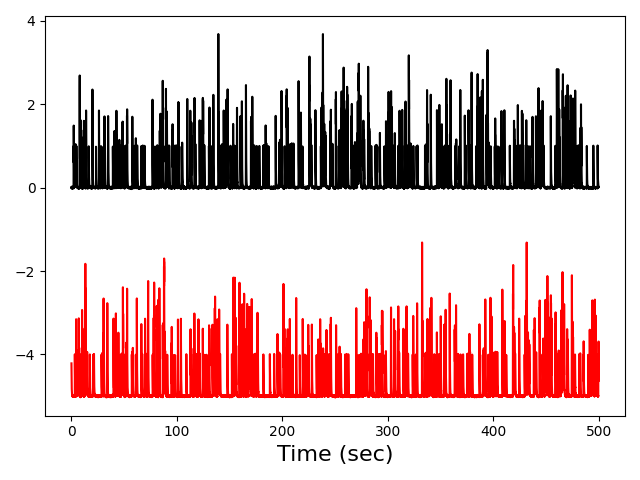

In [28]:

plt.figure()
plt.plot(time_vector,input_signal,'k')
plt.plot(time_vector,input_signal_shifted-5,'r')
plt.xlabel('Time (sec)', fontsize=16)
plt.tight_layout()
plt.show()

# os.chdir(path + '/figures/')
# plt.savefig('Surrogate_Trace_Example{0}.svg'.format(surr))


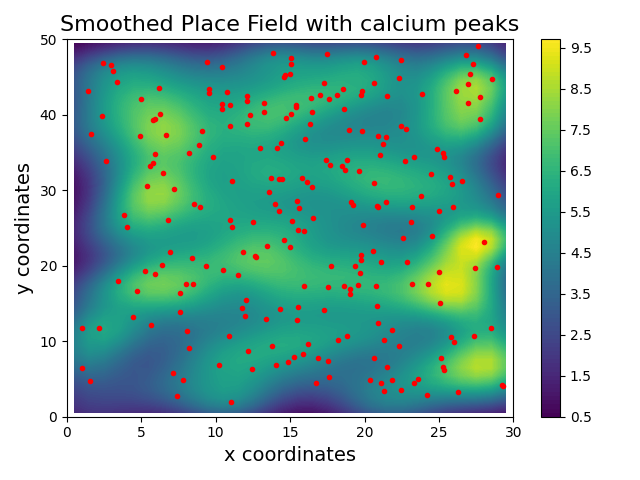

In [29]:


plt.figure()
plt.contourf(place_cell_shuff_output['x_center_bins'],place_cell_shuff_output['y_center_bins'],place_cell_shuff_output['place_field_smoothed'],100,cmap='viridis')
plt.plot(place_cell_shuff_output['x_peaks_location'],place_cell_shuff_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()

plt.show()



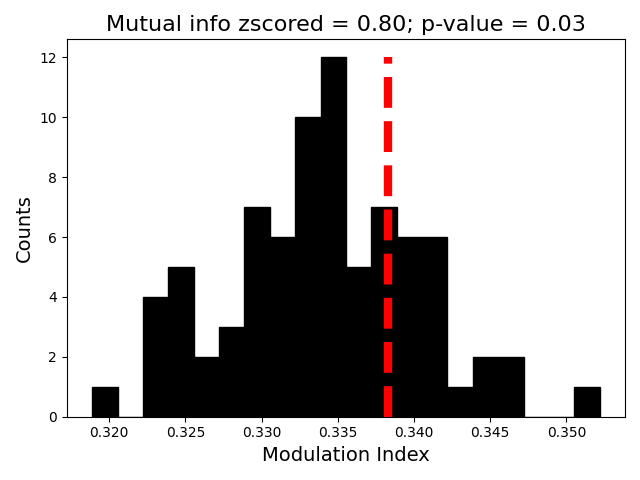

In [30]:
# p value is defined as the place_cell_shuff_output of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shifted'] >= place_cell_shuff_output['mutual_info_original'])/place_cell_shuff_output['mutual_info_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_shuff_output['mutual_info_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_shuff_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_shuff_output['mutual_info_original'],place_cell_shuff_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_shuff_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()
